# tile llc model run and distribute parcels runs

To do:

- [ ] could implement automatic dask cluster killing or restart (if it helps cleanup memory, probably not).
- [ ] check for duplicates prior to store to parquet
- [ ] verify exact continuity at restarts
- [ ] try with different spatial interpolation schemes to measure impact
- [ ] try with different compiler?
- [X] add online horizontal speed output
- [X] change run tree
- [X] add tracer and sea level interpolation. Pressure will always be recomputed offline
- [X] on the fly parcel seeding


In [2]:
import os, shutil

import numpy as np
import pandas as pd
import xarray as xr
from datetime import timedelta, datetime
import geopandas

import dask
from dask.delayed import delayed

%matplotlib inline
from matplotlib import pyplot as plt

import mitequinox.utils as ut
import mitequinox.parcels as pa

INFO: Compiled ParcelsRandom ==> /dev/shm/pbs.8282225.datarmor0/parcels-55081/libparcels_random_e820277e-cecb-4e36-8b0e-c133ee1ff4d1.so


In [3]:
from dask.distributed import Client, LocalCluster
from dask_jobqueue import PBSCluster

# ** processes and cores may be adjusted in order to have more memory or inversely more 
# ** computational ressource

processing = 1

if processing==0:
    cluster = LocalCluster()
elif processing==1:
    # parcels simulation
    cluster = PBSCluster(processes=4, cores=4, walltime='48:00:00')
    w = cluster.scale(jobs=13)
elif processing==2:
    # post processing
    cluster = PBSCluster()
    w = cluster.scale(jobs=2)
    
client = Client(cluster)
client

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/dask_jobqueue/core.py:19: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import format_bytes, parse_bytes, tmpfile
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/dask_jobqueue/core.py:19: FutureWarning: parse_bytes is deprecated and will be removed in a future release. Please use dask.utils.parse_bytes instead.
  from distributed.utils import format_bytes, parse_bytes, tmpfile
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/dask_jobqueue/core.py:19: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import format_bytes, parse_bytes, tmpfile
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/dask_jobqueue/htcondor.py:6: FutureWarning: pars

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.148.0.126:8787/status,
Dashboard: http://10.148.0.126:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.148.0.126:60710,Workers: 0
Dashboard: http://10.148.0.126:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


---
## setup directories and run parameters

In [4]:
#root_dir = '/home1/scratch/aponte/parcels/'
root_dir = '/home/datawork-lops-osi/equinox/mit4320/parcels/'
#root_dir = '/home1/datawork/slgentil/parcels/'

# 5x5 tiles dij=100 T=365 5jobs x 5workers
#run_name = 'global_T365j_dt1j_dij50'
#run_name = 'debug'
run_name = 'global_extra_T365j_dt1j_dij50_new'

overwrite=False

In [5]:
# create run directory tree
dirs = pa.create_dir_tree(root_dir, run_name, overwrite=overwrite)

Not overwriting /home/datawork-lops-osi/equinox/mit4320/parcels/global_extra_T365j_dt1j_dij50_new
Not overwriting /home/datawork-lops-osi/equinox/mit4320/parcels/global_extra_T365j_dt1j_dij50_new/run
Not overwriting /home/datawork-lops-osi/equinox/mit4320/parcels/global_extra_T365j_dt1j_dij50_new/tiling
Not overwriting /home/datawork-lops-osi/equinox/mit4320/parcels/global_extra_T365j_dt1j_dij50_new/parquets
Not overwriting /home/datawork-lops-osi/equinox/mit4320/parcels/global_extra_T365j_dt1j_dij50_new/diagnostics


---

## load llc data

In [6]:
# load llc data
ds = ut.load_data(V=['SSU', 'SSV', 'Eta', 'SST', 'SSS'])
grd = ut.load_grd()[['XC', 'YC', 'XG', 'YG']]
ds = xr.merge([ds, grd])
#ds

---

## create tiles

*Several tiles in the south and north tiles could be deleted eventually as they are on land or not relevant with criterium on Depth or SST*

See `rearrange.ipynb` and `tile.ipynb` for more details

In [7]:
#create_tiles = False
create_tiles = overwrite

if create_tiles:
    # create tiling
    _ds = grd.reset_coords().persist()
    tl = pa.tiler(ds=_ds, factor=(5, 10), overlap=(250, 250))
    # store tiler
    tl.store(dirs["tiling"])
else:
    tl = pa.tiler(tile_dir=dirs["tiling"])

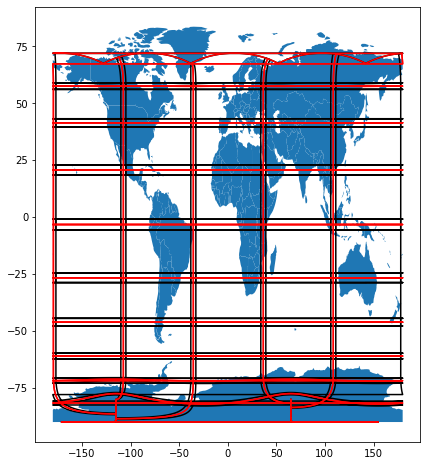

In [7]:
crs = tl.crs_wgs84

world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))
new_world = world.to_crs(crs)

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
new_world.plot(ax=ax)
for t in tl.G['tiles']:
    t.to_crs(crs).boundary.plot(ax=ax, color="black")
for b in tl.G['boundaries']:
    b.to_crs(crs).boundary.plot(ax=ax, color="red")
#ax.set_axis_off()
plt.show()

--- 

## loop over time windows (main loop)


In [8]:
# simulation parameters

T = 360 # length of the total run [days]
#T = 20 # ** debug

dt_window = timedelta(days=1.)
dt_outputs = timedelta(hours=1.)
dt_step = timedelta(hours=1.)
dt_seed = 10 # in days

init_dij = 50 # initial position subsampling compared to llc grid

In [9]:
# restart control
restart = -1 # 0: no restart, -1: last index, precise index otherwise

In [10]:
# create run directories, erase them if need be
_overwrite=False
if restart==0 and overwrite:
    _overwrite = True
tl.create_tile_run_tree(dirs["run"], overwrite=_overwrite)

# set start and end times
t_start = ut.np64toDate(ds['time'][0].values)
t_end = t_start + int(T/dt_window.days)*dt_window
print('Global start = {}  /  Global end = {} '
      .format(t_start.strftime("%Y-%m-%d:%H"),
              t_end.strftime("%Y-%m-%d:%H"),
             )
     )

# get new log filename for this run
log_file = pa.name_log_file(dirs['run'])

if restart==-1:
    log = pa.browse_log_files(dirs['run'])
    if log:
        restart = max(list(log))+1
    else:
        restart = 0

# clean up data for restart
tl.clean_up(dirs["run"], restart)

if restart==0:
    global_parcel_number = 0
    local_numbers = {tile: 0 for tile in range(tl.N_tiles)}
    max_ids = {tile: None for tile in range(tl.N_tiles)}
else:
    #print(log, restart)
    _log = log[restart-1]
    global_parcel_number = _log['global_parcel_number']
    #local_numbers = _log['local_numbers'] # TMP !!!
    max_ids = _log['max_ids']

# debug
#id_max=None

# skips steps if restart
step_t = list(enumerate(ut.dateRange(t_start, t_end, dt_window)))[restart:]

def format_info(step, t_start, t_end):
    print('-------------------------------------------')
    print('step={}  /  start={}  /  end={}'
          .format(step,
                  t_start.strftime("%Y-%m-%d:%H"),
                  t_end.strftime("%Y-%m-%d:%H"),
                 )
         )

Not overwriting /home/datawork-lops-osi/equinox/mit4320/parcels/global_extra_T365j_dt1j_dij50_new/run/data_000
Not overwriting /home/datawork-lops-osi/equinox/mit4320/parcels/global_extra_T365j_dt1j_dij50_new/run/data_001
Not overwriting /home/datawork-lops-osi/equinox/mit4320/parcels/global_extra_T365j_dt1j_dij50_new/run/data_002
Not overwriting /home/datawork-lops-osi/equinox/mit4320/parcels/global_extra_T365j_dt1j_dij50_new/run/data_003
Not overwriting /home/datawork-lops-osi/equinox/mit4320/parcels/global_extra_T365j_dt1j_dij50_new/run/data_004
Not overwriting /home/datawork-lops-osi/equinox/mit4320/parcels/global_extra_T365j_dt1j_dij50_new/run/data_005
Not overwriting /home/datawork-lops-osi/equinox/mit4320/parcels/global_extra_T365j_dt1j_dij50_new/run/data_006
Not overwriting /home/datawork-lops-osi/equinox/mit4320/parcels/global_extra_T365j_dt1j_dij50_new/run/data_007
Not overwriting /home/datawork-lops-osi/equinox/mit4320/parcels/global_extra_T365j_dt1j_dij50_new/run/data_008
N

❤️💕😊😊😊😊😊😊😊

In [ ]:
step_window_delayed = delayed(pa.step_window)

import gc
import ctypes
def trim_memory() -> int:
     libc = ctypes.CDLL("libc.so.6")
     return libc.malloc_trim(0)

for step, local_t_start in step_t:

    local_t_end = local_t_start+dt_window+dt_step

    # print step info
    format_info(step, local_t_start, local_t_end)

    # load, tile (and store) llc data
    ds_tiles = pa.tile_store_llc(ds,
                                 slice(local_t_start, local_t_end, None),
                                 tl,
                                 netcdf=False,
                                )
    # should test how much ds_tiles represents once loaded in memory and compare it to
    # the 750GB observed while running parcels

    # seed with more particles
    seed = ( (local_t_start-t_start).days%dt_seed == 0 )

    global_parcel_number0 = global_parcel_number

    dsteps = [step_window_delayed(tile, step, 
                                      local_t_start, local_t_end,
                                      dt_window, dt_step, dt_outputs,
                                      tl,
                                      ds_tile=ds_tiles[tile], 
                                      init_dij=init_dij, 
                                      parcels_remove_on_land=True,
                                      pclass="extended",
                                      id_max=max_ids[tile],
                                      seed=seed,
                                     )
              for tile in range(tl.N_tiles)
             ]
    try:
        dsteps_out = dask.compute(*dsteps)
    except:
        cluster.close()
        break
        
    # try to manually clean up memory
    # https://coiled.io/blog/tackling-unmanaged-memory-with-dask/
    client.run(gc.collect)
    client.run(trim_memory)

    # update number of global number of drifters and maximum ids for each tiles
    _local_numbers = list(zip(*dsteps_out))[0]
    global_parcel_number = sum(_local_numbers)
    max_ids = {tile: int(out[1]) for tile, out in enumerate(dsteps_out)}
    local_numbers = {tile: int(out) for tile, out in enumerate(_local_numbers)}
    log = dict(global_parcel_number=global_parcel_number,
               local_numbers=local_numbers,
               max_ids=max_ids,
              )

    # store log
    pa.store_log(log_file, step, log)

    print('Total number of particles = {}  ({:+d})'
          .format(global_parcel_number, 
                  global_parcel_number-global_parcel_number0,
                 )
         )

-------------------------------------------
step=141  /  start=2012-04-04:00  /  end=2012-04-05:01
Total number of particles = 69045  (-27)
-------------------------------------------
step=142  /  start=2012-04-05:00  /  end=2012-04-06:01
Total number of particles = 69019  (-26)
-------------------------------------------
step=143  /  start=2012-04-06:00  /  end=2012-04-07:01
Total number of particles = 68992  (-27)
-------------------------------------------
step=144  /  start=2012-04-07:00  /  end=2012-04-08:01
Total number of particles = 68960  (-32)
-------------------------------------------
step=145  /  start=2012-04-08:00  /  end=2012-04-09:01
Total number of particles = 68927  (-33)
-------------------------------------------
step=146  /  start=2012-04-09:00  /  end=2012-04-10:01
Total number of particles = 68878  (-49)
-------------------------------------------
step=147  /  start=2012-04-10:00  /  end=2012-04-11:01
Total number of particles = 68841  (-37)
--------------------

In [12]:
cluster.close()

In [14]:
#import gc
#client.run(gc.collect)

In [17]:
#ds_tiles = [_ds.persist() for _ds in ds_tiles]
# 220GB in RAM against 750 GB observed

In [19]:
import parcels

In [20]:
parcels.__version__

'2.2.2'

In [ ]:
client.restart()

---

## quick pick

In [4]:
ds, dirs = pa.load_info(root_dir, run_name)

In [5]:
df = pa.load_nc(dirs["run"], index='time', persist=True)
df.head()

,trajectory,lat,lon,z,zonal_velocity,meridional_velocity,sea_level,temperature,salinity
time,,,,,,,,,
2011-11-15,39000000,57.835732,-178.867081,0.0,0.0,0.0,0.0,0.0,0.0
2011-11-15,39000001,58.429878,-178.871994,0.0,0.0,0.0,0.0,0.0,0.0
2011-11-15,39000002,59.018066,-178.879623,0.0,0.0,0.0,0.0,0.0,0.0
2011-11-15,39000003,59.600288,-178.890015,0.0,0.0,0.0,0.0,0.0,0.0
2011-11-15,39000004,60.176525,-178.903275,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
tmin = str(df.index.min().compute() + timedelta(days=1.))
tmax = str(df.index.max().compute())
print(tmin, tmax)

2011-11-16 00:00:00 2012-11-09 01:00:00


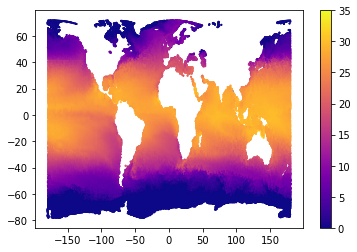

In [8]:

_df = df.loc[tmin].compute()
plt.scatter(_df['lon'], _df['lat'], s=1, c=_df['temperature'], 
            vmin=0, vmax=35, cmap='plasma')
plt.colorbar()

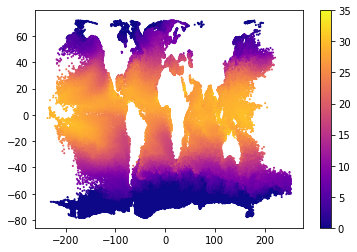

In [9]:
_df = df.loc[tmax, :].compute()
plt.scatter(_df['lon'], _df['lat'], s=1, c=_df['temperature'], 
            vmin=0, vmax=35, cmap='plasma')
plt.colorbar()

---
## load netcdf file and store in parquet format
faster to reload from the netcdf files with right index than to change index of the dask dataframe

In [4]:
ds, dirs = pa.load_logs(root_dir, run_name)

### save with time index

In [5]:
%%time
df = pa.load_nc(dirs["run"], index='time')
pa.store_parquet(dirs["parquets"], df, index='time', overwrite=True)

deleting existing archive: /home1/datawork/aponte/parcels/global_extra_T365j_dt1j_dij50/parquets/time
create new archive: /home1/datawork/aponte/parcels/global_extra_T365j_dt1j_dij50/parquets/time
CPU times: user 2min 27s, sys: 5.87 s, total: 2min 33s
Wall time: 4min 38s


'/home1/datawork/aponte/parcels/global_extra_T365j_dt1j_dij50/parquets/time'

### save with trajectory id index

In [7]:
%%time
df = pa.load_nc(dirs["run"], index='trajectory')
pa.store_parquet(dirs["parquets"], df, index='trajectory', overwrite=True)

deleting existing archive: /home1/datawork/aponte/parcels/global_extra_T365j_dt1j_dij50/parquets/trajectory
create new archive: /home1/datawork/aponte/parcels/global_extra_T365j_dt1j_dij50/parquets/trajectory
CPU times: user 2min 18s, sys: 5.72 s, total: 2min 23s
Wall time: 4min 37s


'/home1/datawork/aponte/parcels/global_extra_T365j_dt1j_dij50/parquets/trajectory'

### save with H3 geographic index

In [ ]:
%%time
df = pa.load_nc(dirs["run"], index='trajectory')
df = pa.h3_index(df)
pa.store_parquet(dirs["parquets"], df, index='hex_id', overwrite=True)

## Close cluster

In [ ]:
cluster.close()